In [1]:
#Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import os
import glob
import random

import imgaug
from imgaug import augmenters as iaa
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import openslide
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, concatenate, Concatenate, UpSampling2D, Activation
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras import metrics

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms  # noqa

import sklearn.metrics
import io
import itertools
from six.moves import range

import time
import cv2
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu

import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from models.seg_models import unet_densenet121, get_inception_resnet_v2_unet_softmax
# Random Seeds
np.random.seed(0)
random.seed(0)
tf.set_random_seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import tifffile 
import skimage.io as io
import pandas as pd
import json

In [2]:
# Image Helper Functions
def imsave(*args, **kwargs):
     """
     Concatenate the images given in args and saves them as a single image in the specified output destination.
     Images should be numpy arrays and have same dimensions along the 0 axis.
     imsave(im1,im2,out="sample.png")
     """
     args_list = list(args)
     for i in range(len(args_list)):
         if type(args_list[i]) != np.ndarray:
             print("Not a numpy array")
             return 0
         if len(args_list[i].shape) == 2:
             args_list[i] = np.dstack([args_list[i]]*3)
             if args_list[i].max() == 1:
                args_list[i] = args_list[i]*255

     out_destination = kwargs.get("out",'')
     try:
         concatenated_arr = np.concatenate(args_list,axis=1)
         im = Image.fromarray(np.uint8(concatenated_arr))
     except Exception as e:
         print(e)
         import ipdb; ipdb.set_trace()
         return 0
     if out_destination:
         print(f"Saving to {out_destination}")
         im.save(out_destination)
     else:
        return im
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage:
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    axis_off = kwargs.get('axis_off','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
            if axis_off: 
              plt.axis('off')  
    plt.show()
def normalize_minmax(data):
    """
    Normalize contrast across volume
    """
    _min = np.float(np.min(data))
    _max = np.float(np.max(data))
    if (_max-_min)!=0:
        img = (data - _min) / (_max-_min)
    else:
        img = np.zeros_like(data)            
    return img

# Functions
def BinMorphoProcessMask(mask):
    """
    Binary operation performed on tissue mask
    """
    close_kernel = np.ones((20, 20), dtype=np.uint8)
    image_close = cv2.morphologyEx(np.array(mask), cv2.MORPH_CLOSE, close_kernel)
    open_kernel = np.ones((5, 5), dtype=np.uint8)
    image_open = cv2.morphologyEx(np.array(image_close), cv2.MORPH_OPEN, open_kernel)
    kernel = np.ones((20, 20), dtype=np.uint8)
    image = cv2.dilate(image_open,kernel,iterations = 1)
    return image
def get_bbox(cont_img, rgb_image=None):
    contours, _ = cv2.findContours(cont_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rgb_contour = None
    if rgb_image is not None:
        rgb_contour = rgb_image.copy()
        line_color = (0, 0, 255)  # blue color code
        cv2.drawContours(rgb_contour, contours, -1, line_color, 2)
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    for x, y, h, w in bounding_boxes:
        rgb_contour = cv2.rectangle(rgb_contour,(x,y),(x+h,y+w),(0,255,0),2)
    return bounding_boxes, rgb_contour
def get_all_bbox_masks(mask, stride_factor):
    """
    Find the bbox and corresponding masks
    """
    bbox_mask = np.zeros_like(mask)
    bounding_boxes, _ = get_bbox(mask)
    y_size, x_size = bbox_mask.shape
    for x, y, h, w in bounding_boxes:
        x_min = x - stride_factor
        x_max = x + h + stride_factor
        y_min = y - stride_factor
        y_max = y + w + stride_factor
        if x_min < 0: 
         x_min = 0
        if y_min < 0: 
         y_min = 0
        if x_max > x_size: 
         x_max = x_size - 1
        if y_max > y_size: 
         y_max = y_size - 1      
        bbox_mask[y_min:y_max, x_min:x_max]=1
    return bbox_mask
def get_all_bbox_masks_with_stride(mask, stride_factor):
    """
    Find the bbox and corresponding masks
    """
    bbox_mask = np.zeros_like(mask)
    bounding_boxes, _ = get_bbox(mask)
    y_size, x_size = bbox_mask.shape
    for x, y, h, w in bounding_boxes:
        x_min = x - stride_factor
        x_max = x + h + stride_factor
        y_min = y - stride_factor
        y_max = y + w + stride_factor
        if x_min < 0: 
         x_min = 0
        if y_min < 0: 
         y_min = 0
        if x_max > x_size: 
         x_max = x_size - 1
        if y_max > y_size: 
         y_max = y_size - 1      
        bbox_mask[y_min:y_max:stride_factor, x_min:x_max:stride_factor]=1
        
    return bbox_mask
def find_largest_bbox(mask, stride_factor):
    """
    Find the largest bounding box encompassing all the blobs
    """
    y_size, x_size = mask.shape
    x, y = np.where(mask==1)
    bbox_mask = np.zeros_like(mask)
    x_min = np.min(x) - stride_factor
    x_max = np.max(x) + stride_factor
    y_min = np.min(y) - stride_factor
    y_max = np.max(y) + stride_factor
    
    if x_min < 0: 
     x_min = 0
    
    if y_min < 0: 
     y_min = 0

    if x_max > x_size: 
     x_max = x_size - 1
    
    if y_min > y_size: 
     y_max = y_size - 1    
    
    bbox_mask[x_min:x_max, y_min:y_max]=1
    return bbox_mask
    
def TissueMaskGeneration(slide_obj, level, RGB_min=50):
    img_RGB = slide_obj.read_region((0, 0),level,slide_obj.level_dimensions[level])
    img_RGB = np.transpose((img_RGB.convert('RGB')),axes=[1,0,2])
    img_HSV = rgb2hsv(img_RGB)
    background_R = img_RGB[:, :, 0] > threshold_otsu(img_RGB[:, :, 0])
    background_G = img_RGB[:, :, 1] > threshold_otsu(img_RGB[:, :, 1])
    background_B = img_RGB[:, :, 2] > threshold_otsu(img_RGB[:, :, 2])
    tissue_RGB = np.logical_not(background_R & background_G & background_B)
    tissue_S = img_HSV[:, :, 1] > threshold_otsu(img_HSV[:, :, 1])
    min_R = img_RGB[:, :, 0] > RGB_min
    min_G = img_RGB[:, :, 1] > RGB_min
    min_B = img_RGB[:, :, 2] > RGB_min

    tissue_mask = tissue_S & tissue_RGB & min_R & min_G & min_B
    # r = img_RGB[:,:,0] < 235
    # g = img_RGB[:,:,1] < 210
    # b = img_RGB[:,:,2] < 235
    # tissue_mask = np.logical_or(r,np.logical_or(g,b))
    return tissue_mask 
def TissueMaskGenerationPatch(patchRGB):
    '''
    Returns mask of tissue that obeys the threshold set by paip
    '''
    r = patchRGB[:,:,0] < 235
    g = patchRGB[:,:,1] < 210
    b = patchRGB[:,:,2] < 235
    tissue_mask = np.logical_or(r,np.logical_or(g,b))
    return tissue_mask 
    
def TissueMaskGeneration_BIN(slide_obj, level):
    img_RGB = np.transpose(np.array(slide_obj.read_region((0, 0),
                       level,
                       slide_obj.level_dimensions[level]).convert('RGB')),
                       axes=[1, 0, 2])    
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2HSV)
    img_S = img_HSV[:, :, 1]
    _,tissue_mask = cv2.threshold(img_S, 0, 255, cv2.THRESH_BINARY)
    return np.array(tissue_mask)

def TissueMaskGeneration_BIN_OTSU(slide_obj, level):
    img_RGB = np.transpose(np.array(slide_obj.read_region((0, 0),
                       level,
                       slide_obj.level_dimensions[level]).convert('RGB')),
                       axes=[1, 0, 2])    
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2HSV)
    img_S = img_HSV[:, :, 1]
    _,tissue_mask = cv2.threshold(img_S, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return np.array(tissue_mask)

def labelthreshold(image, threshold=0.5):
    label = np.zeros_like(image)
    label[image>=threshold] = 1
#     np.place(image,image>=threshold, 1)
#     np.place(image,image<threshold, 0)
    return np.uint8(label)

def calc_jacc_score(x,y,smoothing=1):
    for var in [x,y]:
        np.place(var,var==255,1)
    
    numerator = np.sum(x*y)
    denominator = np.sum(np.logical_or(x,y))
    return (numerator+smoothing)/(denominator+smoothing)
    

def get_tumor_fraction(mask_image):
    fraction = np.count_nonzero(mask_image)/np.prod(mask_image.shape)
    return fraction

In [3]:
# DataLoader Implementation
class WSIStridedPatchDataset(Dataset):
    """
    Data producer that generate all the square grids, e.g. 3x3, of patches,
    from a WSI and its tissue mask, and their corresponding indices with
    respect to the tissue mask
    """
    def __init__(self, wsi_path, mask_path, label_path=None, image_size=256,
                 normalize=True, flip='NONE', rotate='NONE',                
                 level=5, sampling_stride=16, roi_masking=True):
        """
        Initialize the data producer.

        Arguments:
            wsi_path: string, path to WSI file
            mask_path: string, path to mask file in numpy format OR None
            label_mask_path: string, path to ground-truth label mask path in tif file or
                            None (incase of Normal WSI or test-time)
            image_size: int, size of the image before splitting into grid, e.g. 768
            patch_size: int, size of the patch, e.g. 256
            crop_size: int, size of the final crop that is feed into a CNN,
                e.g. 224 for ResNet
            normalize: bool, if normalize the [0, 255] pixel values to [-1, 1],
                mostly False for debuging purpose
            flip: string, 'NONE' or 'FLIP_LEFT_RIGHT' indicating the flip type
            rotate: string, 'NONE' or 'ROTATE_90' or 'ROTATE_180' or
                'ROTATE_270', indicating the rotate type
            level: Level to extract the WSI tissue mask
            roi_masking: True: Multiplies the strided WSI with tissue mask to eliminate white spaces,
                                False: Ensures inference is done on the entire WSI   
            sampling_stride: Number of pixels to skip in the tissue mask, basically it's the overlap
                            fraction when patches are extracted from WSI during inference.
                            stride=1 -> consecutive pixels are utilized
                            stride= image_size/pow(2, level) -> non-overalaping patches 
        """
        self._wsi_path = wsi_path
        self._mask_path = mask_path
        self._label_path = label_path
        self._image_size = image_size
        self._normalize = normalize
        self._flip = flip
        self._rotate = rotate
        self._level = level
        self._sampling_stride = sampling_stride
        self._roi_masking = roi_masking
        
        self._preprocess()

    def _preprocess(self):
        self._slide = openslide.OpenSlide(self._wsi_path)
        
        if self._label_path is not None:
            self._label_slide = openslide.OpenSlide(self._label_path)
        
        X_slide, Y_slide = self._slide.level_dimensions[0]
        print("Image dimensions: (%d,%d)" %(X_slide,Y_slide))
        
        factor = self._sampling_stride

        
        if self._mask_path is not None:
            mask_file_name = os.path.basename(self._mask_path)
            if mask_file_name.endswith('.tiff'):
                mask_obj = openslide.OpenSlide(self._mask_path)
                self._mask = np.array(mask_obj.read_region((0, 0),
                       self._level,
                       mask_obj.level_dimensions[self._level]).convert('L')).T
                np.place(self._mask,self._mask>0,255)
        else:
            # Generate tissue mask on the fly    
            
            self._mask = TissueMaskGeneration(self._slide, self._level)
        # morphological operations ensure the holes are filled in tissue mask
        # and minor points are aggregated to form a larger chunk         

        self._mask = BinMorphoProcessMask(np.uint8(self._mask))
        # self._all_bbox_mask = get_all_bbox_masks(self._mask, factor)
        # self._largest_bbox_mask = find_largest_bbox(self._mask, factor)
        # self._all_strided_bbox_mask = get_all_bbox_masks_with_stride(self._mask, factor)

        X_mask, Y_mask = self._mask.shape
        # print (self._mask.shape, np.where(self._mask>0))
        # imshow(self._mask.T)
        # cm17 dataset had issues with images being power's of 2 precisely        
#         if X_slide != X_mask or Y_slide != Y_mask:
        print('Mask (%d,%d) and Slide(%d,%d) '%(X_mask,Y_mask,X_slide,Y_slide))
        if X_slide // X_mask != Y_slide // Y_mask:
            raise Exception('Slide/Mask dimension does not match ,'
                            ' X_slide / X_mask : {} / {},'
                            ' Y_slide / Y_mask : {} / {}'
                            .format(X_slide, X_mask, Y_slide, Y_mask))

        self._resolution = np.round(X_slide * 1.0 / X_mask)
        if not np.log2(self._resolution).is_integer():
            raise Exception('Resolution (X_slide / X_mask) is not power of 2 :'
                            ' {}'.format(self._resolution))
             
        # all the idces for tissue region from the tissue mask  
        self._strided_mask =  np.ones_like(self._mask)
        ones_mask = np.zeros_like(self._mask)
        ones_mask[::factor, ::factor] = self._strided_mask[::factor, ::factor]
        
        
        if self._roi_masking:
            self._strided_mask = ones_mask*self._mask   
            # self._strided_mask = ones_mask*self._largest_bbox_mask   
            # self._strided_mask = ones_mask*self._all_bbox_mask 
            # self._strided_mask = self._all_strided_bbox_mask  
        else:
            self._strided_mask = ones_mask  
        # print (np.count_nonzero(self._strided_mask), np.count_nonzero(self._mask[::factor, ::factor]))
        # imshow(self._strided_mask.T, self._mask[::factor, ::factor].T)
        # imshow(self._mask.T, self._strided_mask.T)
 
        self._X_idcs, self._Y_idcs = np.where(self._strided_mask)        
        self._idcs_num = len(self._X_idcs)

    def __len__(self):        
        return self._idcs_num 

    def save_scaled_imgs(self):
        scld_dms = self._slide.level_dimensions[2]
        self._slide_scld = np.transpose(self._slide.read_region((0,0),2,scld_dms).convert('RGB'),[1,0,2])
        
        if self._label_path is not None:
            self._label_scld = np.array(self._label_slide.read_region((0,0),4,scld_dms).convert('L')).T
            np.place(self._label_scld,self._label_scld>0,255)
        
    def save_get_mask(self, save_path):
        np.save(save_path, self._mask)

    def get_mask(self):
        return self._mask

    def get_strided_mask(self):
        return self._strided_mask
    
    def __getitem__(self, idx):
        x_coord, y_coord = self._X_idcs[idx], self._Y_idcs[idx]
        
        x_max_dim,y_max_dim = self._slide.level_dimensions[0]

        # x = int(x_coord * self._resolution)
        # y = int(y_coord * self._resolution)    

        x = int(x_coord * self._resolution - self._image_size//2)
        y = int(y_coord * self._resolution - self._image_size//2)    
#         x = int(x_coord * self._resolution)
#         y = int(y_coord * self._resolution)    
        
        #If Image goes out of bounds
        if x>(x_max_dim - image_size):
            x = x_max_dim - image_size
        elif x<0:
            x = 0
        if y>(y_max_dim - image_size):
            y = y_max_dim - image_size
        elif y<0:
            y = 0
    
        #Converting pil image to np array transposes the w and h
        img = np.transpose(self._slide.read_region(
            (x, y), 0, (self._image_size, self._image_size)).convert('RGB'),[1,0,2])
        
        if self._label_path is not None:
            label_img = np.transpose(self._label_slide.read_region(
                (x, y), 0, (self._image_size, self._image_size)).convert('L'),[1,0])
        else:
            #print('No label img')
            label_img = np.transpose(Image.fromarray(np.zeros((self._image_size, self._image_size), dtype=np.uint8)))
        
        if self._flip == 'FLIP_LEFT_RIGHT':
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            label_img = label_img.transpose(Image.FLIP_LEFT_RIGHT)
            
        if self._rotate == 'ROTATE_90':
            img = img.transpose(Image.ROTATE_90)
            label_img = label_img.transpose(Image.ROTATE_90)
            
        if self._rotate == 'ROTATE_180':
            img = img.transpose(Image.ROTATE_180)
            label_img = label_img.transpose(Image.ROTATE_180)

        if self._rotate == 'ROTATE_270':
            img = img.transpose(Image.ROTATE_270)
            label_img = label_img.transpose(Image.ROTATE_270)

        # PIL image:   H x W x C
        img = np.array(img, dtype=np.float32)
        label_img = np.array(label_img, dtype=np.uint8)
        np.place(label_img, label_img>0, 255)

        if self._normalize:
            img = (img - 128.0)/128.0
   
        return (img, x, y, label_img)

In [5]:
#Model
model = get_inception_resnet_v2_unet_softmax((None, None), weights=None)
#model_path = glob.glob('../../results/saved_models/dense_80k/fold2/model.06*')[0]
model_root_path = '../../results/saved_models/incep_viable_200k/'
model_path = glob.glob(os.path.join(model_root_path,'5fold_0/model.10*'))[0]
core_config = tf.ConfigProto()
core_config.gpu_options.allow_growth = False
# core_config.gpu_options.per_process_gpu_memory_fraction=0.4
session =tf.Session(config=core_config) 
K.set_session(session)

model.load_weights(model_path)
print ("Loaded Model Weights")

W0821 22:48:53.950547 140406833321728 deprecation.py:506] From /home/brats/miniconda/envs/dl/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loaded Model Weights


Training_phase_1_015
Image dimensions: (49799,45396)
Mask (3112,2837) and Slide(49799,45396) 


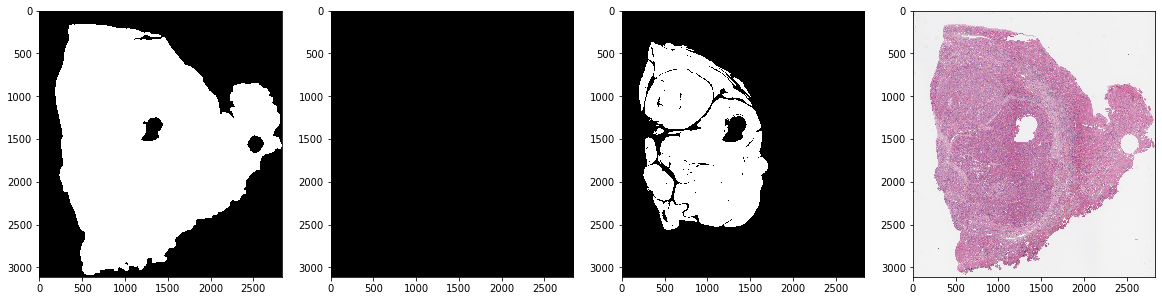

Total iterations: 152
Completed 0 Time elapsed 0.30 min
0.0 217789
Completed 100 Time elapsed 14.81 min
380552011.0 405136578


ValueError: invalid mode: 'Training_phase_1_015.json'

In [9]:
#Stitcher
start_time = time.time()
kfold_k = 5
fold = 0
mask_path = None
batch_size = 1
image_size = 1024
im_by2 = image_size//2
im_by4 = image_size//4
sampling_stride = image_size #At the 0 level
batch_size = 8
mining_threshold = 0.6 #Lesser than which to mine points

mined_points_path = os.path.join(model_root_path, 'mined_points','%dfold_%d'%(kfold_k,fold))
try:
    os.makedirs(mined_points_path)
except FileExistsError:
    if os.listdir(mined_points_path) != []:
        raise FileExistsError
        
def save_mined_points(x,y,tf):
    if tf > 0.0:
        coord_type = 'normal'
    else:
        coord_type = 'tumor'
        
    with open(os.path.join(mined_points_path,'%s.txt' % coord_type),'a') as f:
        f.write('%s,%s,%d,%d,%f\n'%(wsi_path,label_path,x,y,tf))
        
#Get train ids from cv split file containing path to wsi images
sample_ids = [ x.split('/')[-2] for x in list(pd.read_csv('../../data/raw-data/cross_val_splits_%d_whole/training_fold_%d.csv'%(kfold_k,fold))['Image_Path'])]
for sample_id in sample_ids:
    print(sample_id)
        
    sample_dir = os.path.join('..','..','data','raw-data','train',sample_id)
    wsi_path = glob.glob(os.path.join(sample_dir,'*.svs'))[0]
    label_path = glob.glob(os.path.join(sample_dir,'*viable*.tiff'))[0]
    dataset_obj = WSIStridedPatchDataset(wsi_path, 
                                        mask_path,
                                        label_path,
                                        image_size=image_size,
                                        normalize=True,
                                        flip=None, rotate=None,
                                        level=2, sampling_stride=sampling_stride//16, roi_masking=True)
    
    meta_dict= {'num': 0, 'den': 0, 'jaccs':[]}

    wsi_obj = openslide.OpenSlide(wsi_path)
    x_max_dim,y_max_dim = wsi_obj.level_dimensions[0]
    scld_dms = wsi_obj.level_dimensions[2]
    prd_im_fll = np.zeros(wsi_obj.level_dimensions[0])
    scale = lambda x: cv2.resize(x,tuple(reversed(scld_dms))).T
    
    dataloader = DataLoader(dataset_obj, batch_size=batch_size, num_workers=0, drop_last=True)
    dataset_obj.save_scaled_imgs()
    imshow(dataset_obj.get_mask(), dataset_obj.get_strided_mask(), dataset_obj._label_scld, dataset_obj._slide_scld)
    
    print("Total iterations: %d" % dataloader.__len__())
    for i,(data, x, y, label) in enumerate(dataloader):
        #print(i,x,y)
        image_patches = data.cpu().data.numpy()
        patch_mask = TissueMaskGenerationPatch(image_patches[0]*128+128)
        label_patches = label.cpu().data.numpy()
        
        pred_map = model.predict(image_patches,verbose=0,batch_size=1)
        for j in range(batch_size):
            jacc_score = calc_jacc_score(labelthreshold(pred_map[j,:,:,1],threshold=0.45),label_patches[j])
            meta_dict['jaccs'].append(jacc_score)
            meta_dict['num']+=int(np.sum(labelthreshold(pred_map[j,:,:,1],threshold=0.45)*label_patches[j].clip(max=1)))
            meta_dict['den']+=int(np.sum(np.logical_or(labelthreshold(pred_map[j,:,:,1],threshold=0.45),label_patches[j])))
            
            if jacc_score < mining_threshold:
                #top-left
                tf = get_tumor_fraction(label_patches[j,:im_by2,:im_by2])
                point_x = int(x[j]) + im_by4
                point_y = int(y[j]) + im_by4
                save_mined_points(point_x,point_y,tf)
                    
                #top-right
                tf = get_tumor_fraction(label_patches[j,:im_by2,im_by2:image_size])
                point_y += im_by4
                save_mined_points(point_x,point_y,tf)
                    
                #bottom-right
                tf = get_tumor_fraction(label_patches[j,im_by2:image_size,im_by2:image_size])
                point_x += im_by4
                save_mined_points(point_x,point_y,tf)
                    
                #bottom-right
                tf = get_tumor_fraction(label_patches[j,im_by2:image_size,:im_by2])
                point_y -= im_by4
                save_mined_points(point_x,point_y,tf)
                
            #print("Jaccard: %.3f" %(jacc_score))
#             imshow(pred_map[j,:,:,1],label_patches[j],np.uint8(image_patches[j]*128+128))
            #imshow(pred_map[j,:,:,1],labelthreshold(pred_map[j,:,:,1],0.45),label_patches[j])
                                                                         
        if (i)%100==0:
            print("Completed %i Time elapsed %.2f min"%(i,(time.time()-start_time)/60))
            start_time = time.time()
            print(meta_dict['num'],meta_dict['den'])
    meta_dict['jaccs_index'] = meta_dict['num']/meta_dict['den']
    meta_dict['histogram'] = str(np.histogram(meta_dict['jaccs'], bins=11))
    with open(os.path.join(mined_points_path, sample_id+'.json'),'w') as f:
        json.dump(meta_dict,f)

    break